In [1]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [2]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from src.visual_analysis.visual_analysis import *


# DEFINIZIONE DATA BASE

In [ ]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 100
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})


# SPLIT DATASET

In [4]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
from src.preprocessing.dataset import parse_ravdess_filename

def split_by_speakers(filepaths, train_speakers, val_speakers, test_speakers):
    train, val, test = [], [], []
    for fp in filepaths:
        actor = parse_ravdess_filename(fp)["actor"]
        if actor in train_speakers:
            train.append(fp)
        elif actor in val_speakers:
            val.append(fp)
        elif actor in test_speakers:
            test.append(fp)
    return train, val, test

In [6]:

# 3) split random stratificato (Phase 1: NON speaker-independent)
train_files, temp_files, train_y, temp_y = train_test_split(
   all_files, labels, test_size=0.30, random_state=42, stratify=labels
)
val_files, test_files, _, _ = train_test_split(
    temp_files, temp_y, test_size=0.50, random_state=42, stratify=temp_y
)

print(f"Split -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# Speaker-independent split (attori disgiunti)
#train_spk = [f"{i:02d}" for i in range(1, 17)]   # 01..18
#val_spk   = [f"{i:02d}" for i in range(17, 21)]  # 19..22
#test_spk  = [f"{i:02d}" for i in range(21, 25)]  # 23..24

#train_files, val_files, test_files = split_by_speakers(all_files, train_spk, val_spk, test_spk)

#print(f"Split SI -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

from collections import Counter
import torch

train_labels = [extract_label_idx(fp) for fp in train_files]
counts = Counter(train_labels)

weights = torch.tensor([1.0 / counts[i] for i in range(8)], dtype=torch.float, device=device)
weights = weights / weights.sum() * 8  # normalizzazione

print("Class counts:", counts)
print("Weights:", weights.detach().cpu().numpy())

# 4) dataset + loader
AUG_ON = True  # <-- switch globale (metti False per disattivare tutto)

aug_cfg = {
    "gain": True,
    "gain_db": (-3, 3),

    "time_shift": True,
    "time_shift_s": 0.03,   

    "noise": True,
    "snr_db": (25, 40),  
    "vtlp": False,   

    "reverb": True,
    "reverb_ir_s": 0.04,
    "reverb_decay": 0.25,
}


train_ds = RavdessDataset(train_files, augmentation=AUG_ON, aug_config=aug_cfg)
val_ds   = RavdessDataset(val_files,   augmentation=False)   # NO augmentation su val
test_ds  = RavdessDataset(test_files,  augmentation=False)   # NO augmentation su test

# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 5) model
model = CRNN(n_classes=8, n_mels=64).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# HISTORY PER GRAFICO 
val_acc_hist = []
test_acc_hist = []


Split -> train 1008 | val 216 | test 216
Class counts: Counter({6: 135, 1: 135, 2: 135, 4: 134, 7: 134, 3: 134, 5: 134, 0: 67})
Weights: [1.7821782  0.88448846 0.88448846 0.8910891  0.8910891  0.8910891
 0.88448846 0.8910891 ]


c:\Users\franc\Politecnico Di Torino Studenti Dropbox\Francesca Melloni\POLITO\2°anno, I semestre\ML\venv310\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [7]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y, weight=weights, label_smoothing=0.1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/30 | train loss 2.0904 acc 0.1190 | val loss 2.0516 acc 0.1759 | test acc 0.1852
Epoch 2/30 | train loss 2.0607 acc 0.1607 | val loss 1.9921 acc 0.2407 | test acc 0.2361
Epoch 3/30 | train loss 2.0117 acc 0.2242 | val loss 1.9209 acc 0.3009 | test acc 0.2824
Epoch 4/30 | train loss 1.9486 acc 0.2520 | val loss 1.8301 acc 0.3333 | test acc 0.2731
Epoch 5/30 | train loss 1.9331 acc 0.2510 | val loss 1.7955 acc 0.3194 | test acc 0.3333
Epoch 6/30 | train loss 1.8965 acc 0.2946 | val loss 1.7496 acc 0.3611 | test acc 0.3796
Epoch 7/30 | train loss 1.8352 acc 0.3313 | val loss 1.7290 acc 0.3704 | test acc 0.3657
Epoch 8/30 | train loss 1.7927 acc 0.3462 | val loss 1.6599 acc 0.3750 | test acc 0.3704
Epoch 9/30 | train loss 1.7693 acc 0.3730 | val loss 1.6809 acc 0.3704 | test acc 0.3704
Epoch 10/30 | train loss 1.7384 acc 0.3661 | val loss 1.5490 acc 0.5046 | test acc 0.4537
Epoch 11/30 | train loss 1.6938 acc 0.4018 | val loss 1.5381 acc 0.4213 | test acc 0.4583
Epoch 12/30 | train

In [ ]:

# VISUAL ANALYSIS
# t-SNE on embeddings + Grad-CAM su spettrogrammi

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.preprocessing.dataset import IDX2LABEL, parse_ravdess_filename

#t-SNE on embeddings 
@torch.no_grad()
def extract_crnn_embeddings(model, loader, device, return_paths=True):
    """
    Estrae embeddings dal CRNN SENZA modificare la classe.
    Qui definiamo "embedding" come il vettore dopo:
    CNN -> BiLSTM -> mean pooling temporale, prima del classifier.
    
    Ritorna:
      - emb: [N, D] numpy
      - y_true: [N] numpy
      - y_pred: [N] numpy
      - paths: lista file (opzionale)
    """
    model.eval()
    embs = []
    ys = []
    preds = []
    paths = []

    # Se il tuo Dataset non restituisce il path, lo ricaviamo via loader.dataset.filepaths
    # assumendo che loader NON shuffli (true per val/test nel tuo notebook)
    dataset_paths = getattr(loader.dataset, "filepaths", None)
    global_index = 0

    for batch in loader:
        x, y = batch
        x = x.to(device)

        # --- ricostruzione "forward fino all'embedding" basata sulla tua CRNN ---
        feat = model.cnn(x)                      # [B, C, M', T']
        b, c, m, t = feat.shape
        feat = feat.permute(0, 3, 1, 2).contiguous()  # [B, T', C, M']
        feat = feat.view(b, t, c * m)                 # [B, T', C*M']
        seq, _ = model.rnn(feat)                      # [B, T', 2H]
        emb = seq.mean(dim=1)                         # [B, 2H]  <-- embedding

        logits = model.classifier(emb)                # [B, n_classes]
        y_hat = logits.argmax(dim=1)

        embs.append(emb.detach().cpu())
        ys.append(y.detach().cpu())
        preds.append(y_hat.detach().cpu())

        if return_paths and dataset_paths is not None:
            bs = y.size(0)
            paths.extend(dataset_paths[global_index: global_index + bs])
            global_index += bs

    embs = torch.cat(embs, dim=0).numpy()
    ys = torch.cat(ys, dim=0).numpy()
    preds = torch.cat(preds, dim=0).numpy()

    return embs, ys, preds, paths


def tsne_project(embeddings, pca_dim=50, tsne_perplexity=30, tsne_lr="auto", seed=42):
    """
    PCA (opzionale) + t-SNE -> 2D
    """
    X = embeddings
    if pca_dim is not None and X.shape[1] > pca_dim:
        X = PCA(n_components=pca_dim, random_state=seed).fit_transform(X)

    tsne = TSNE(
        n_components=2,
        perplexity=tsne_perplexity,
        learning_rate=tsne_lr,
        init="pca",
        random_state=seed
    )
    Z = tsne.fit_transform(X)
    return Z


def plot_tsne_by_label(Z, y_true, title="t-SNE (colored by true label)"):
    plt.figure(figsize=(10, 7))
    for k in np.unique(y_true):
        idx = (y_true == k)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=18, alpha=0.75, label=IDX2LABEL[int(k)])
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.legend(markerscale=1.2, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_tsne_errors_and_speakers(Z, y_true, y_pred, paths, title="t-SNE (errors + speaker id)"):
    """
    Plot originale: evidenziamo errori e aggiungiamo speaker id.
    - corretto: marker 'o'
    - errato: marker 'x'
    Colore: emotion vera
    """
    correct = (y_true == y_pred)

    # Speaker/actor id dal filename (RAVDESS Actor_XX)
    speakers = []
    for fp in paths:
        actor = parse_ravdess_filename(fp)["actor"]
        speakers.append(actor)
    speakers = np.array(speakers)

    plt.figure(figsize=(10, 7))

    # Per non avere 24 legende, mettiamo speaker id come testo solo per alcuni punti (campionamento)
    # e ci concentriamo su errori vs corretti
    for k in np.unique(y_true):
        idx_k = (y_true == k)

        # corretti
        idx_ok = idx_k & correct
        plt.scatter(Z[idx_ok, 0], Z[idx_ok, 1], s=16, alpha=0.65, marker="o")

        # errati
        idx_bad = idx_k & (~correct)
        if idx_bad.any():
            plt.scatter(Z[idx_bad, 0], Z[idx_bad, 1], s=40, alpha=0.9, marker="x")

    # Aggiungi qualche speaker label sui punti sbagliati (molto utile per capire leakage)
    bad_idx = np.where(~correct)[0]
    for i in bad_idx[:30]:  # limita per non “sporcare” il grafico
        plt.text(Z[i, 0], Z[i, 1], speakers[i], fontsize=8, alpha=0.85)

    plt.title(title + "  (x = misclassified; text = speaker id on some errors)")
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.tight_layout()
    plt.show()

#Grad-CAM on spectrograms
def find_last_conv2d(module: nn.Module):
    """
    Trova automaticamente l'ultimo nn.Conv2d dentro un modello (o sotto-moduli).
    Così se cambi architettura, spesso non devi cambiare nulla.
    """
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("Nessun nn.Conv2d trovato: non posso fare Grad-CAM.")
    return last


class GradCAM:
    """
    Grad-CAM generico:
    - hook su ultimo Conv2d (o quello che passi tu)
    - produce heatmap (H x W) allineata allo spettrogramma input
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_a = target_layer.register_forward_hook(self._forward_hook)
        self.hook_g = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out  # [B, C, H, W]

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # [B, C, H, W]

    def close(self):
        self.hook_a.remove()
        self.hook_g.remove()

    def __call__(self, x, class_idx=None):
        import torch.nn as nn
        import torch.nn.functional as F

        # salva stato originale
        was_training = self.model.training

        # serve per far funzionare backward su cuDNN LSTM
        self.model.train()

        # disattiva dropout per mappe stabili
        for m in self.model.modules():
            if isinstance(m, nn.Dropout):
                m.eval()

        self.model.zero_grad(set_to_none=True)

        logits = self.model(x)  # [1, n_classes]
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())

        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # attivazioni e gradienti dal layer target
        A = self.activations          # [1, C, H, W]
        G = self.gradients            # [1, C, H, W]
        if A is None or G is None:
            raise RuntimeError("Hooks Grad-CAM non hanno catturato activations/gradients. Controlla target_layer.")

        # pesi: global average pooling dei gradienti
        weights = G.mean(dim=(2, 3), keepdim=True)       # [1, C, 1, 1]

        # somma pesata delle attivazioni
        cam = (weights * A).sum(dim=1, keepdim=True)     # [1, 1, H, W]
        cam = F.relu(cam)

        # normalizzazione
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-9)

        # upsample alla size dello spettrogramma di input
        cam_up = F.interpolate(
            cam,
            size=(x.shape[2], x.shape[3]),
            mode="bilinear",
            align_corners=False
        )  # [1, 1, n_mels, T]

        # ripristina stato originale
        if not was_training:
            self.model.eval()

        return cam_up.detach().cpu().squeeze(0).squeeze(0), class_idx, logits.detach().cpu()



def show_gradcam_on_spectrogram(spec, cam, title="", true_label=None, pred_label=None):
    """
    spec: [1, n_mels, T] tensor (cpu o gpu)
    cam:  [n_mels, T] tensor cpu (da GradCAM)
    """
    spec = spec.detach().cpu().squeeze(0)  # [n_mels, T]

    plt.figure(figsize=(12, 4))
    plt.imshow(spec, aspect="auto", origin="lower")
    plt.imshow(cam, aspect="auto", origin="lower", alpha=0.45)  # overlay
    t = title
    if true_label is not None and pred_label is not None:
        t += f" | true={true_label} pred={pred_label}"
    plt.title(t)
    plt.xlabel("time")
    plt.ylabel("mel bins")
    plt.tight_layout()
    plt.show()


def gradcam_demo(model, loader, device, n_examples=10, seed=42, class_mode="pred"):
    """
    Seleziona n_examples campioni casuali e mostra Grad-CAM.
    class_mode:
      - "pred": spiega la classe predetta
      - "true": spiega la classe vera
    """
    rng = np.random.RandomState(seed)
    idxs = rng.choice(len(loader.dataset), size=min(n_examples, len(loader.dataset)), replace=False)

    target_layer = find_last_conv2d(model)
    cam_engine = GradCAM(model, target_layer)

    model.eval()
    for i in idxs:
        spec, y = loader.dataset[i]  # spec: [1, n_mels, T]
        x = spec.unsqueeze(0).to(device)  # [1,1,n_mels,T]
        y = int(y.item())

        if class_mode == "true":
            cam, cidx, logits = cam_engine(x, class_idx=y)
        else:
            cam, cidx, logits = cam_engine(x, class_idx=None)

        pred = int(logits.argmax(dim=1).item())
        show_gradcam_on_spectrogram(
            spec,
            cam,
            title="C) Grad-CAM on log-mel spectrogram",
            true_label=IDX2LABEL[y],
            pred_label=IDX2LABEL[pred]
        )
    cam_engine.close()


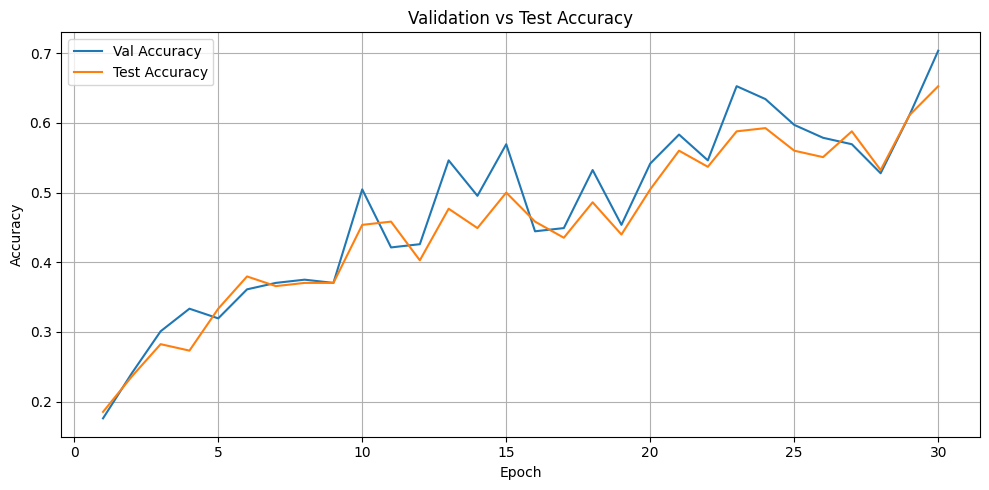


Best val acc: 0.7037037037037037


C:\Users\franc\AppData\Local\Temp\ipykernel_45888\1692596892.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=de

TEST (best checkpoint) | loss 0.9915 acc 0.6528


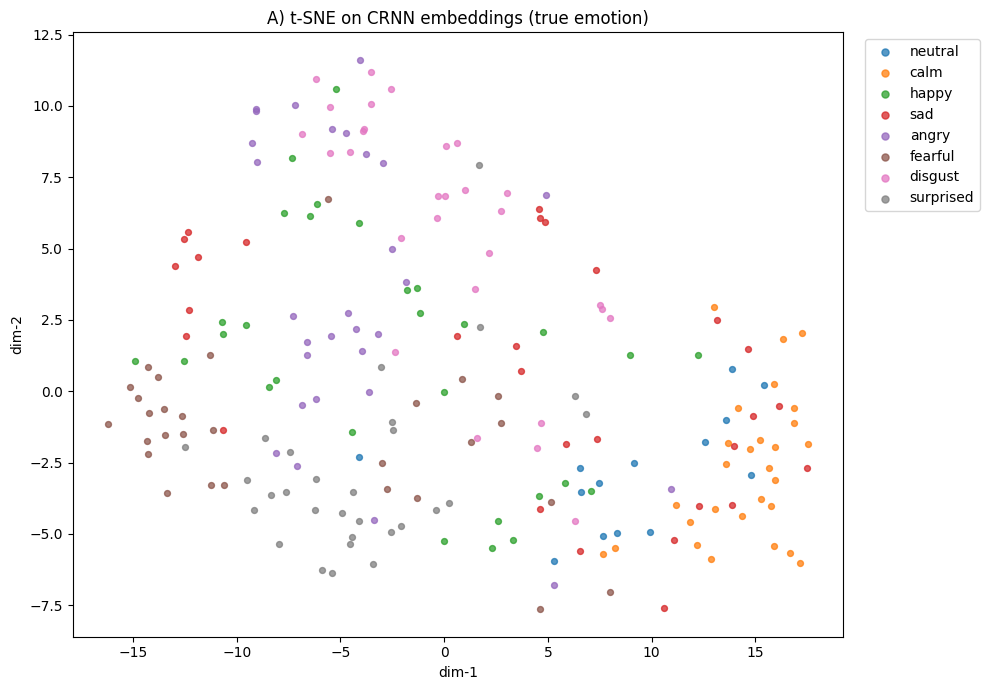

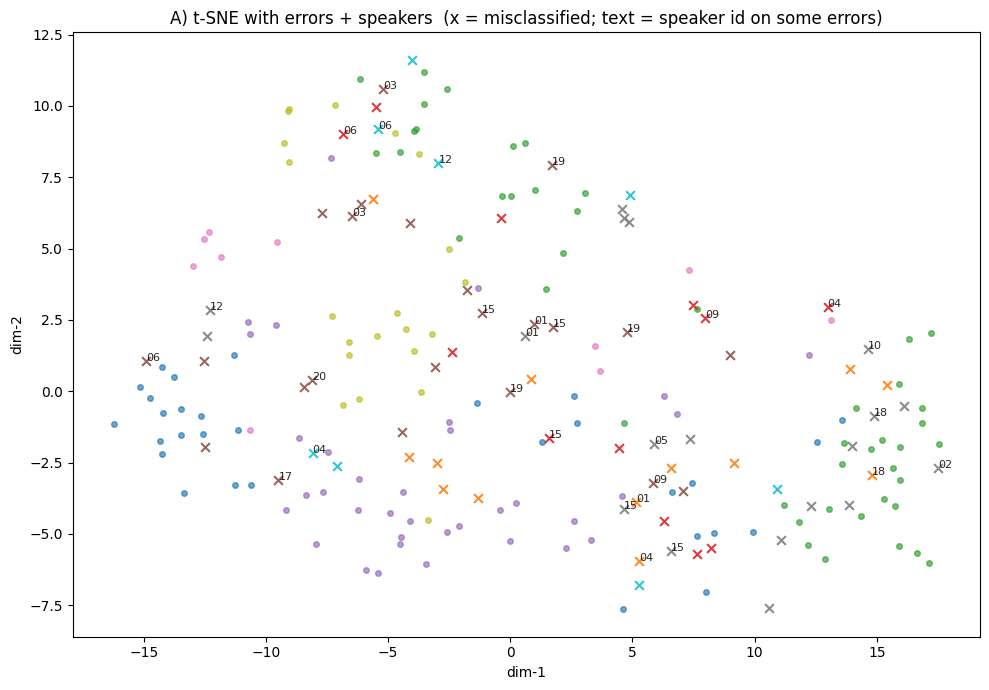

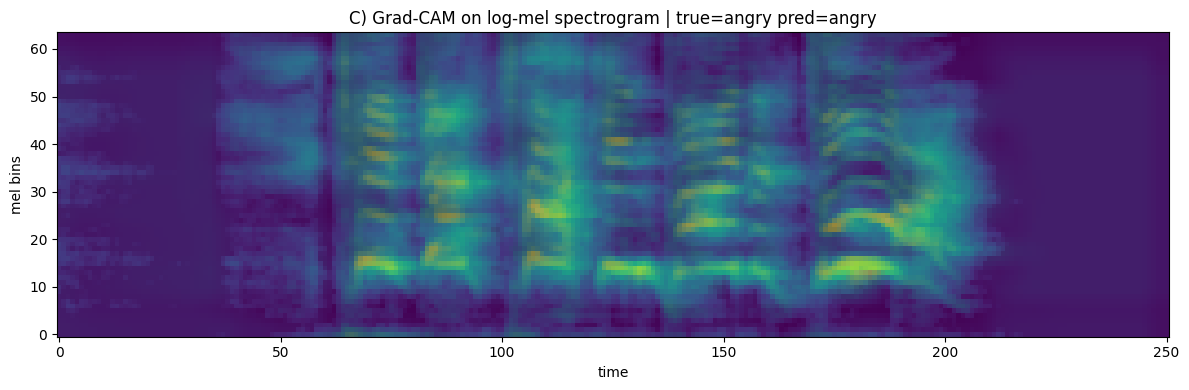

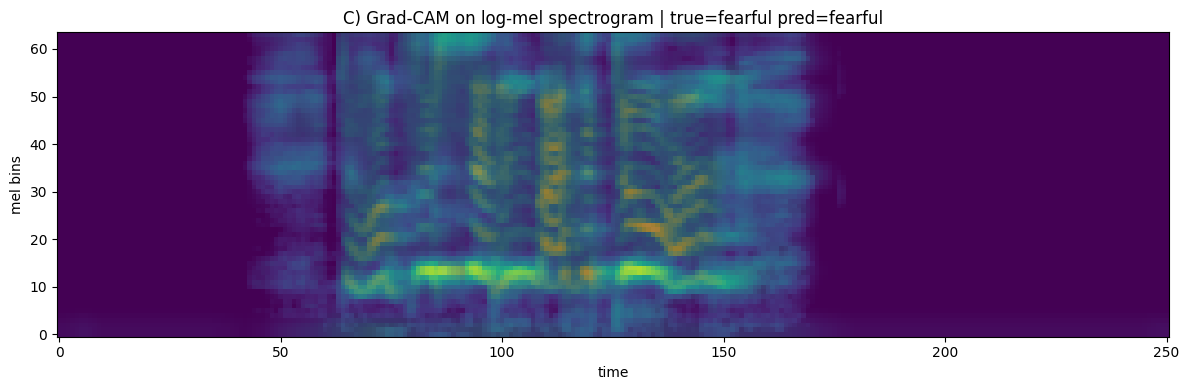

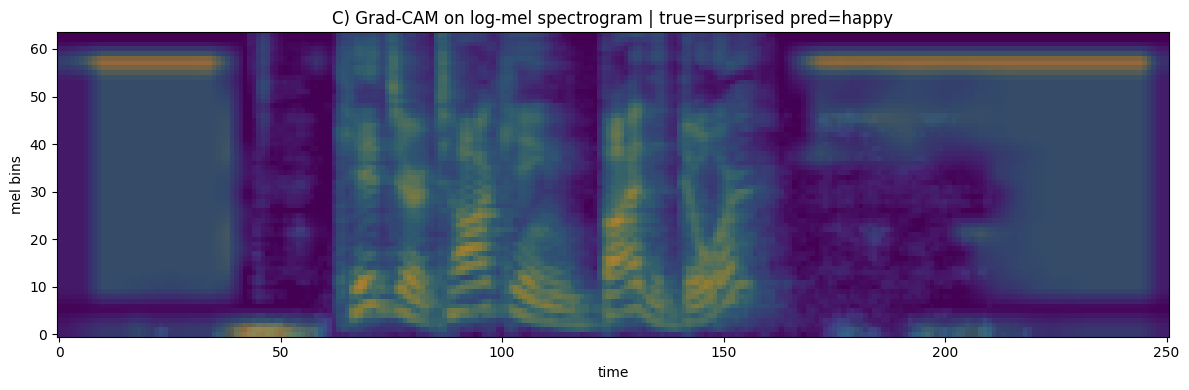

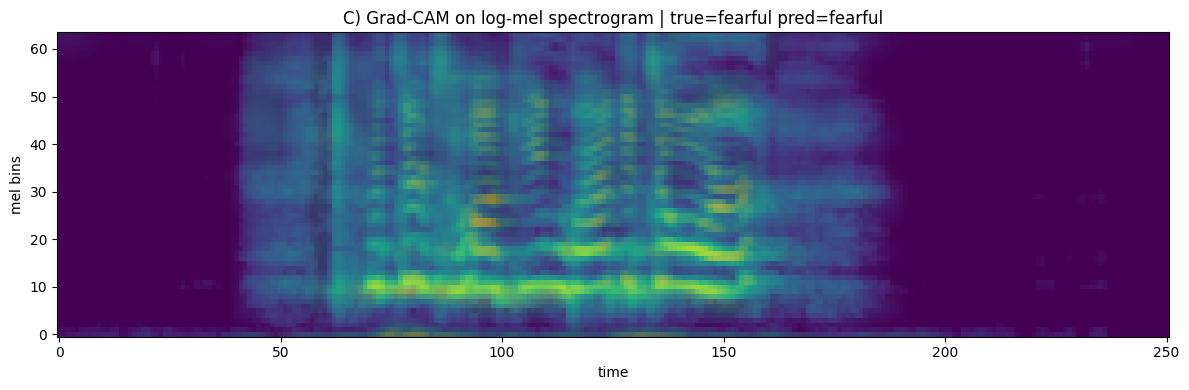

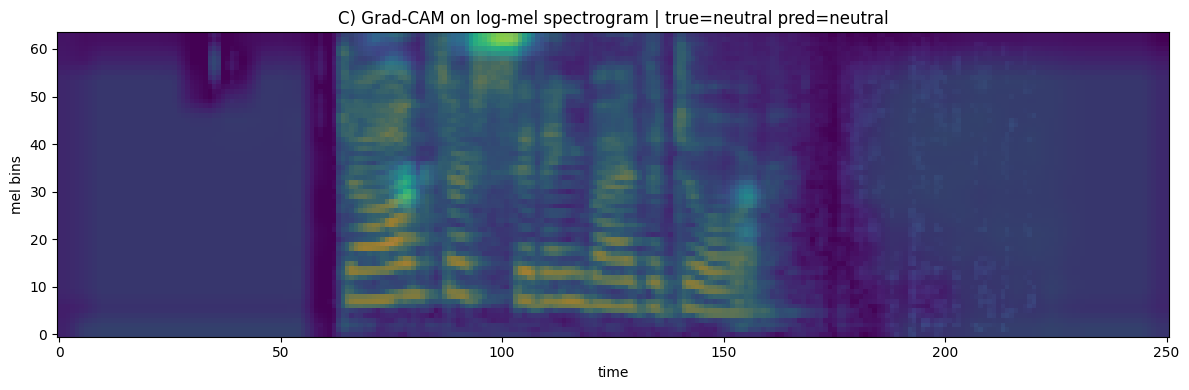

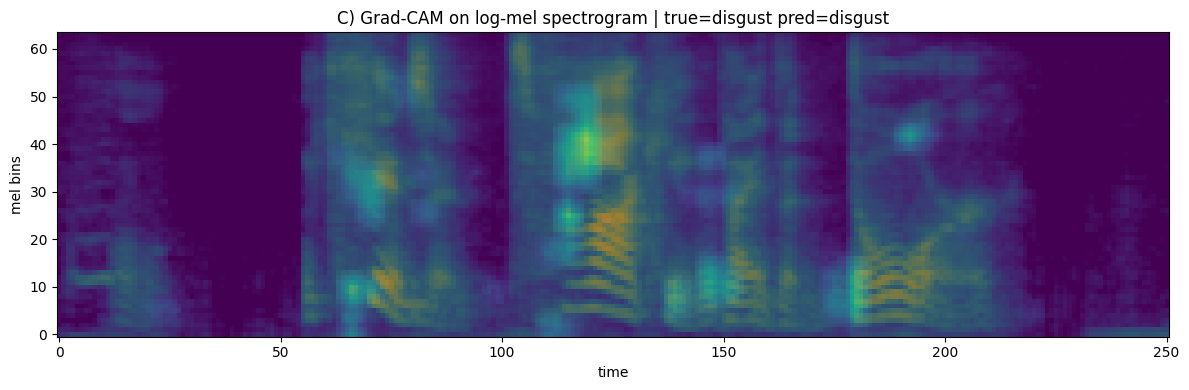

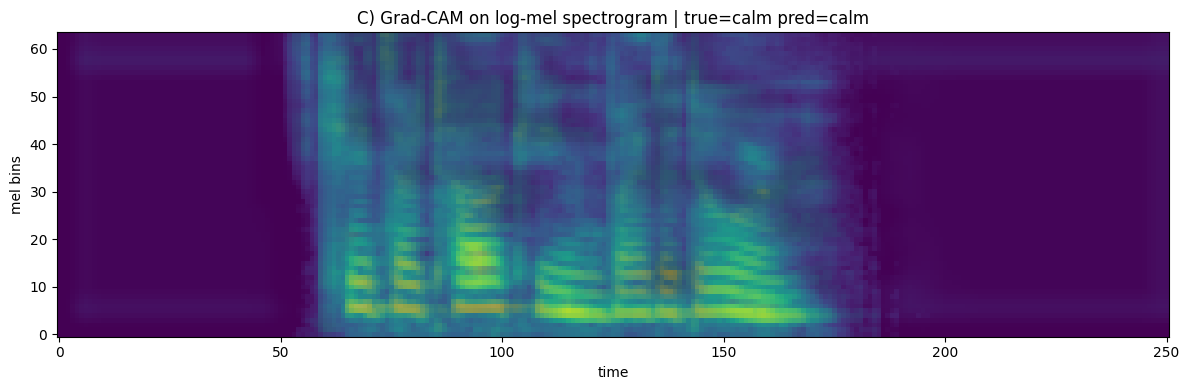

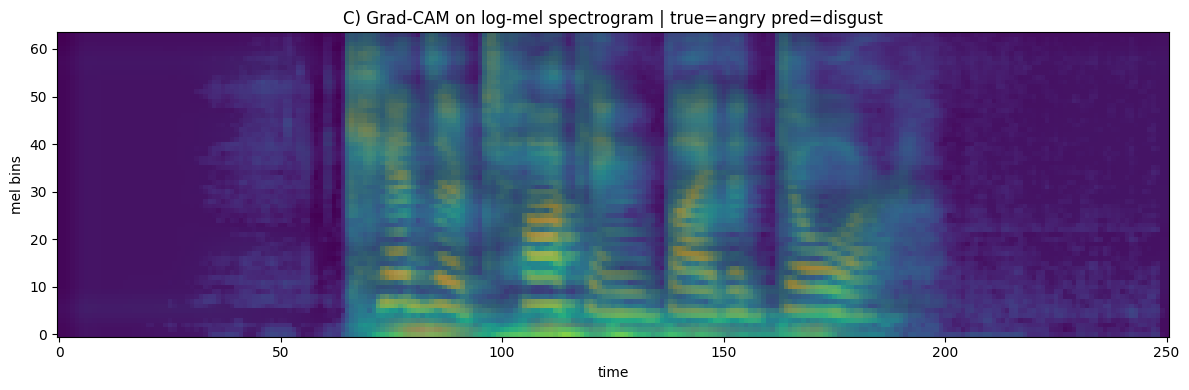

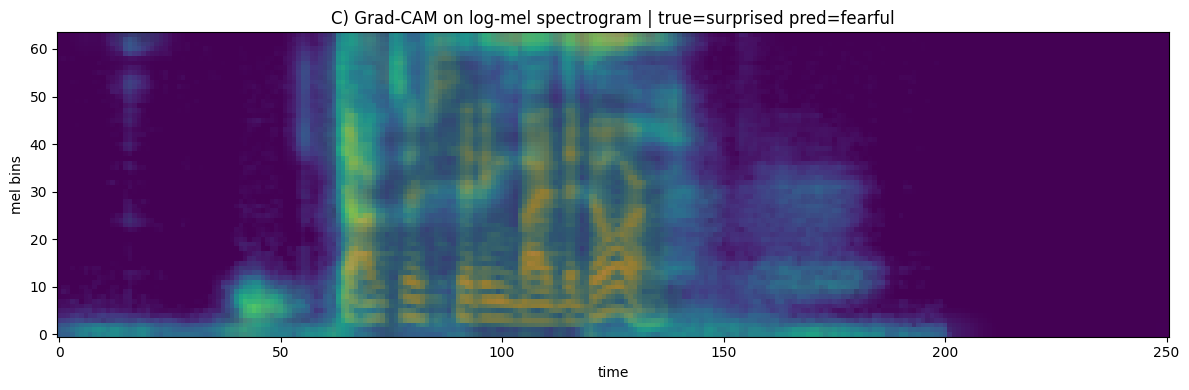

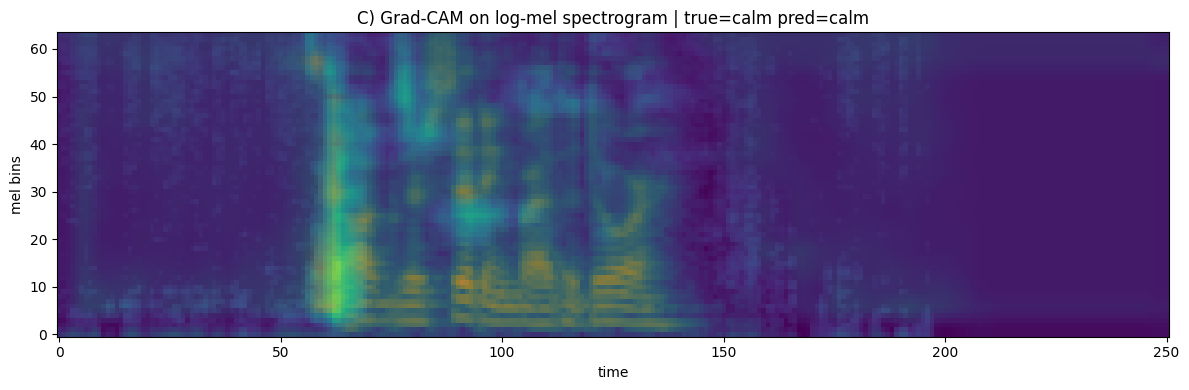


Classification report:
              precision    recall  f1-score   support

     neutral     0.5833    0.5000    0.5385        14
        calm     0.6579    0.8929    0.7576        28
       happy     0.6667    0.4828    0.5600        29
         sad     0.6111    0.3793    0.4681        29
       angry     0.7778    0.7241    0.7500        29
     fearful     0.6154    0.8276    0.7059        29
     disgust     0.6667    0.7586    0.7097        29
   surprised     0.8214    0.7931    0.8070        29

    accuracy                         0.6806       216
   macro avg     0.6750    0.6698    0.6621       216
weighted avg     0.6815    0.6806    0.6702       216

Confusion matrix:
[[ 7  4  2  1  0  0  0  0]
 [ 2 25  0  1  0  0  0  0]
 [ 1  1 14  2  3  6  2  0]
 [ 1  7  3 11  0  4  3  0]
 [ 1  1  0  0 21  0  4  2]
 [ 0  0  2  1  0 24  0  2]
 [ 0  0  0  2  2  2 22  1]
 [ 0  0  0  0  1  3  2 23]]


In [16]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# VISUAL ANALYSIS
emb, y_true_e, y_pred_e, paths = extract_crnn_embeddings(model, test_loader, device, return_paths=True)
Z = tsne_project(emb, pca_dim=50, tsne_perplexity=30, seed=42)

plot_tsne_by_label(Z, y_true_e, title="A) t-SNE on CRNN embeddings (true emotion)")
plot_tsne_errors_and_speakers(Z, y_true_e, y_pred_e, paths, title="A) t-SNE with errors + speakers")

gradcam_demo(model, test_loader, device, n_examples=10, seed=42, class_mode="pred")
# Oppure: spiega la classe vera (utile per capire cosa "dovrebbe" guardare)
# gradcam_demo(model, test_loader, device, n_examples=10, seed=42, class_mode="true")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
target_names = [IDX2LABEL[i] for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
